In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

### Cleaning the data

In [2]:
df = pd.read_csv('cs-training.csv')
df = df.rename(columns={'SeriousDlqin2yrs': 'label'})
df = df.dropna()
df = df.drop(columns=['Unnamed: 0'])

print(len(df))
print(df.head(5))

120269
   label  RevolvingUtilizationOfUnsecuredLines  age  \
0      1                              0.766127   45   
1      0                              0.957151   40   
2      0                              0.658180   38   
3      0                              0.233810   30   
4      0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        

In [3]:
features_count = len(df.columns) - 1
X = df.drop(columns=['label'], axis=1).to_numpy()
y = df['label']

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.30, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.50, random_state=1)

### Define training, val and test datasets and visualize data

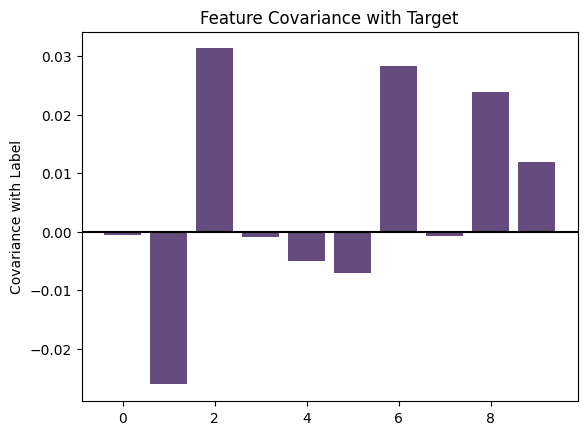

In [4]:
# visualization for feature correlation with the label
X_scaled = StandardScaler().fit_transform(X)
covs = []

for i in range(features_count):
    cov = np.cov(X_scaled[:, i], y)
    covs.append(cov[0, 1])

feature_names = df.drop(columns=['label']).columns.tolist()

plt.bar(range(features_count), covs, color="#654c7e")
plt.axhline(0, color='black')
plt.ylabel('Covariance with Label')
plt.title('Feature Covariance with Target')
plt.show()


### Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.82      0.89     16830
           1       0.20      0.63      0.31      1210

    accuracy                           0.81     18040
   macro avg       0.59      0.72      0.60     18040
weighted avg       0.92      0.81      0.85     18040



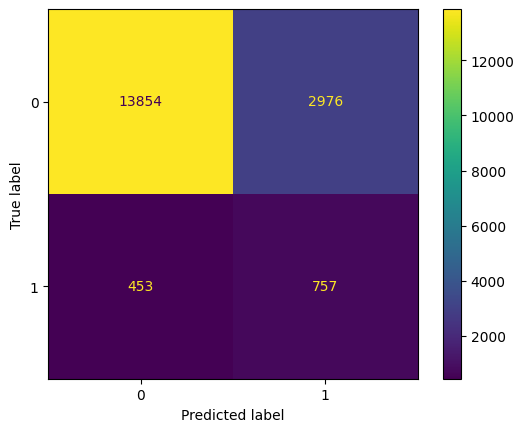

In [5]:
# training and validation set
log_reg = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=1)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_val)

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm, display_labels=log_reg.classes_).plot()

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     16749
           1       0.23      0.62      0.33      1292

    accuracy                           0.82     18041
   macro avg       0.60      0.73      0.61     18041
weighted avg       0.91      0.82      0.86     18041



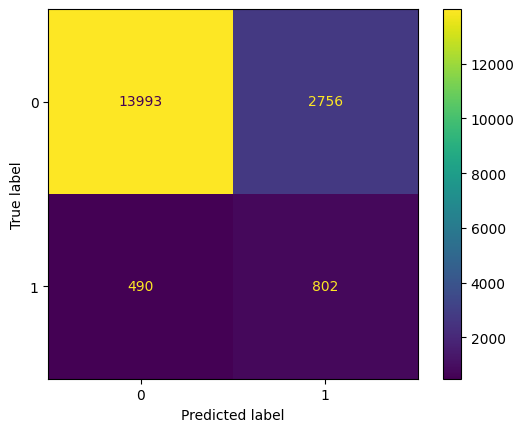

In [6]:
# test set
X_trainval = np.concatenate((X_train, X_val))
y_trainval = np.concatenate((y_train, y_val))
log_reg.fit(X_trainval, y_trainval)
y_test_pred = log_reg.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=log_reg.classes_).plot()

### Random forest

In [7]:
# Grid search to find the best combination of parameters for random forest
base_rf = RandomForestClassifier(class_weight = 'balanced', n_estimators=300, max_depth=10, max_features='sqrt', min_samples_leaf=2, random_state=1)
param_grid = {'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:5}, {0:1, 1:8}, {0:1, 1:10}], 'max_depth': [10, 20, None], 'min_samples_leaf': [1, 2, 4]}
f1_scorer = make_scorer(f1_score)
grid = GridSearchCV(estimator=base_rf, param_grid=param_grid, scoring=f1_scorer, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

print("\nBest parameters found:")
print(grid.best_params_)
print(f"Best mean F1 score (CV): {grid.best_score_:.2f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best parameters found:
{'class_weight': {0: 1, 1: 5}, 'max_depth': 10, 'min_samples_leaf': 4}
Best mean F1 score (CV): 0.43


              precision    recall  f1-score   support

           0       0.96      0.94      0.95     16830
           1       0.38      0.51      0.43      1210

    accuracy                           0.91     18040
   macro avg       0.67      0.72      0.69     18040
weighted avg       0.92      0.91      0.92     18040



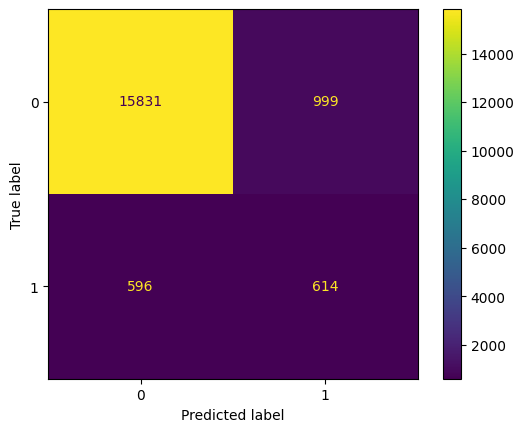

In [8]:
# validation set
best_rf = grid.best_estimator_
y_val_pred = best_rf.predict(X_val)

print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm, display_labels=log_reg.classes_).plot()

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     16749
           1       0.38      0.48      0.43      1292

    accuracy                           0.91     18041
   macro avg       0.67      0.71      0.69     18041
weighted avg       0.92      0.91      0.91     18041



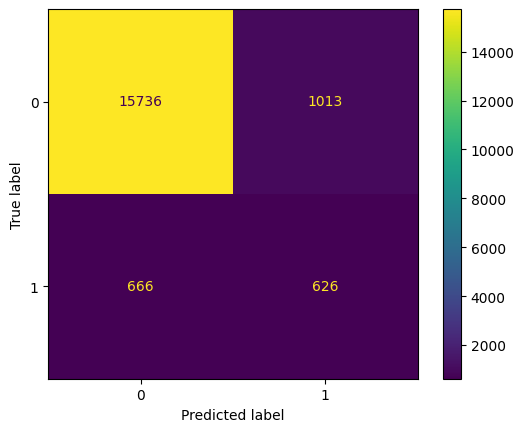

In [9]:
# final test set using the best parameters found
final_rf = RandomForestClassifier(n_estimators=800, max_features='sqrt', class_weight=grid.best_params_['class_weight'], max_depth=grid.best_params_['max_depth'], min_samples_leaf=grid.best_params_['min_samples_leaf'], random_state=1)
X_trainval = np.concatenate((X_train, X_val))
y_trainval = np.concatenate((y_train, y_val))
final_rf.fit(X_trainval, y_trainval)
y_test_pred = final_rf.predict(X_test)

print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=log_reg.classes_).plot()

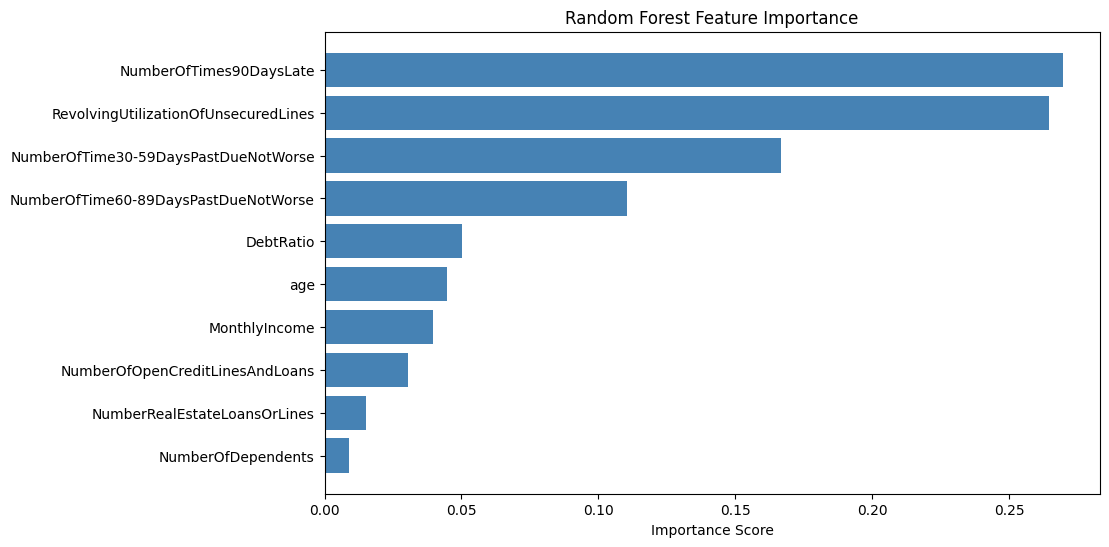

In [10]:
# feature importance for random forest
importances = final_rf.feature_importances_
feature_names = df.drop(columns=['label']).columns
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'], fi_df['Importance'], color='steelblue')
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.show()